**Import Libraries**

In [56]:
import zipfile
import pathlib
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small

**Process Zip File**

In [ ]:
dataset_zip_path = 'dataset_zip/waste_dataset_v2_new.zip'
extract_path = './dataset'

# Create directory to extract files if doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Open and extract zipfile
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Contents of '{dataset_zip_path}' extracted to '{extract_path}'.")

**Convert Dataset Into a Dataframe**

In [57]:
root = './dataset/waste_dataset_v2_new/'

data = {}

# Create dataframe structure
for dir in os.listdir(root):
  for _, subdirs, filenames in os.walk(root+dir):
    for filename in filenames:
      data[root + dir + '/' + filename] = dir

In [58]:
# Convert to dataframe
data=pd.DataFrame(data.items(),columns=['path','category'])
data=data.sample(frac=1)
data

,path,category
2171,./dataset/waste_dataset_v2_new/kain/clothes830...,kain
9639,./dataset/waste_dataset_v2_new/elektronik/Prin...,elektronik
14379,./dataset/waste_dataset_v2_new/kertas/images (...,kertas
11355,./dataset/waste_dataset_v2_new/plastik/100003_...,plastik
9958,./dataset/waste_dataset_v2_new/elektronik/Play...,elektronik
...,...,...
13587,./dataset/waste_dataset_v2_new/organik/biologi...,organik
8747,./dataset/waste_dataset_v2_new/elektronik/Wash...,elektronik
10631,./dataset/waste_dataset_v2_new/plastik/R_978.jpg,plastik
13060,./dataset/waste_dataset_v2_new/organik/biologi...,organik


**Split Data into Training, Validation and Testing Set**

In [60]:
from sklearn.utils import shuffle

# Splittng function
def split_data(data, train_rat, valid_rat):
  """
  Args:
  data: dataset in a dataframe format
  train_rat: ratio of train set to split
  valid_rat: ratio of validation set to split

  Note: remaining ratio would be a test split ratio

  Return:
  (train, valid, test)
  """

  # Shuffle the data
  data_shuffled = shuffle(data, random_state=42)

  train_size = int(len(data_shuffled) * train_rat)
  valid_size = int(len(data_shuffled) * valid_rat)

  # Split the shuffled data
  train = data_shuffled[:train_size]
  valid = data_shuffled[train_size:train_size + valid_size]
  test = data_shuffled[train_size + valid_size:]

  return train, valid, test

In [61]:
# Split the data
train, valid, test = split_data(data, 0.7, 0.15)

Train Data

In [62]:
print("TRAIN DATA")
train_category_counts = train['category'].value_counts()
train_category_counts

TRAIN DATA


category
kaca          1470
logam         1424
kertas        1422
elektronik    1417
organik       1409
kardus        1400
plastik       1364
kain          1353
Name: count, dtype: int64

Validation Data

In [63]:
print("VALIDATION DATA")
valid_category_counts = valid['category'].value_counts()
valid_category_counts

VALIDATION DATA


category
kain          337
plastik       327
kardus        311
organik       301
logam         290
kertas        289
kaca          286
elektronik    271
Name: count, dtype: int64

Test Data

In [64]:
print("TEST DATA")
test_category_counts = test['category'].value_counts()
test_category_counts

TEST DATA


category
elektronik    312
logam         311
kain          311
plastik       309
kaca          300
kardus        291
kertas        290
organik       290
Name: count, dtype: int64

**Genarate Image Data**

In [65]:
BATCH_SIZE = 50
SIZE = 224

# Genarate training set
train_datagen=ImageDataGenerator(
    # rotation_range = 30,
    # width_shift_range = 0.2,
    # height_shift_range = 0.2,
    # zoom_range = 0.2,
    # horizontal_flip = True,
    # fill_mode = 'nearest'
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='path',
    y_col='category',
    target_size=(SIZE, SIZE),
    batch_size= BATCH_SIZE,
    class_mode = "categorical"
    )

# Genarate validation set
valid_datagen=ImageDataGenerator()

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = valid,
    x_col='path',
    y_col='category',
    target_size=(SIZE, SIZE),
    batch_size= BATCH_SIZE,
    class_mode = "categorical"
    )

# Genarate testing set
test_datagen=ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    x_col='path',
    y_col='category',
    target_size=(SIZE, SIZE),
    batch_size= BATCH_SIZE,
    class_mode = "categorical"
    )

Found 11258 validated image filenames belonging to 8 classes.
Found 2412 validated image filenames belonging to 8 classes.
Found 2414 validated image filenames belonging to 8 classes.


/home/qaul19001/.local/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


**Build the Model**

In [67]:
base_model = MobileNetV3Small(input_shape=(224,224,3), classes=8,
                             weights="imagenet", include_top=False)

for layer in base_model.layers[:-5]:
    layer.trainable = False

# pretrained_model.summary()

base_output = base_model.layers[-1].output
x = GlobalAveragePooling2D()(base_output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='softmax')(x)

model = Model(base_model.input, x)

# model.summary()

**Compile and Train the Model**

Train the model, use the optimal learning rate

In [68]:
EPOCHS = 50
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=20,
      epochs=EPOCHS,
      verbose=1,
      validation_data = valid_generator,
      validation_steps=10)

Epoch 1/50
20/20 [==============================] - 10s 364ms/step - loss: 0.9409 - accuracy: 0.6650 - val_loss: 0.4916 - val_accuracy: 0.8220
Epoch 2/50
20/20 [==============================] - 7s 328ms/step - loss: 0.5269 - accuracy: 0.8200 - val_loss: 0.4860 - val_accuracy: 0.8240
Epoch 3/50
20/20 [==============================] - 6s 324ms/step - loss: 0.3739 - accuracy: 0.8870 - val_loss: 0.4676 - val_accuracy: 0.8420
Epoch 4/50
20/20 [==============================] - 7s 329ms/step - loss: 0.3309 - accuracy: 0.8680 - val_loss: 0.3816 - val_accuracy: 0.8920
Epoch 5/50
20/20 [==============================] - 6s 316ms/step - loss: 0.3145 - accuracy: 0.8890 - val_loss: 0.4398 - val_accuracy: 0.8560
Epoch 6/50
20/20 [==============================] - 7s 333ms/step - loss: 0.3069 - accuracy: 0.9061 - val_loss: 0.3205 - val_accuracy: 0.8840
Epoch 7/50
20/20 [==============================] - 6s 323ms/step - loss: 0.2444 - accuracy: 0.9140 - val_loss: 0.3941 - val_accuracy: 0.8760
Epoch

**Evaluate Performance**

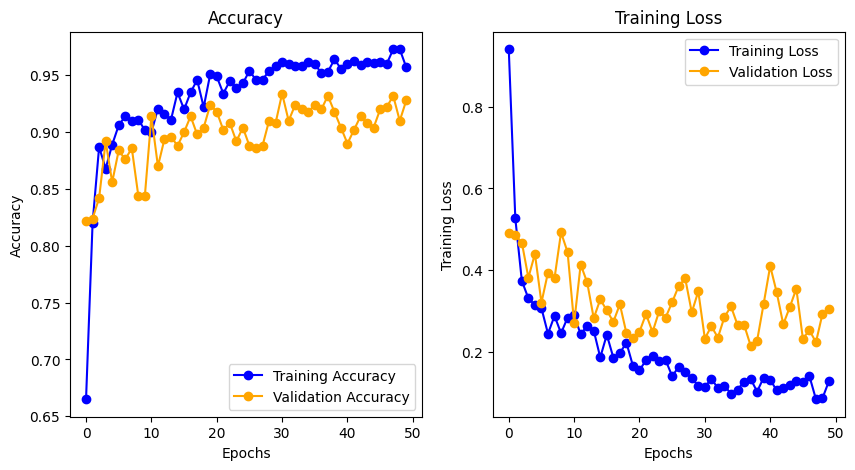

In [69]:
epochs = list(range(len(history.history['accuracy'])))

# Set up the figure
fig , subplot = plt.subplots(1,2)
fig.set_size_inches(10,5)

# Get accuracy and lost history
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot Accuracy
subplot[0].plot(epochs , train_acc , 'o-' ,color='b', label = 'Training Accuracy')
subplot[0].plot(epochs , val_acc , 'o-' , color='orange', label = 'Validation Accuracy')
subplot[0].set_title('Accuracy')
subplot[0].legend()
subplot[0].set_xlabel("Epochs")
subplot[0].set_ylabel("Accuracy")

# Plot Loss
subplot[1].plot(epochs , train_loss , 'o-' ,color='b', label = 'Training Loss')
subplot[1].plot(epochs , val_loss , 'o-' , color='orange', label = 'Validation Loss')
subplot[1].set_title('Training Loss')
subplot[1].legend()
subplot[1].set_xlabel("Epochs")
subplot[1].set_ylabel("Training Loss")
plt.show()

**Evalute Model on Test Set**

In [70]:
results = model.evaluate(test_generator)
accuracy_index = model.metrics_names.index('accuracy')

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.labels


49/49 [==============================] - 10s 192ms/step


**Inspect Prediction for Random Images**

In [71]:
# Genarate plot set
plot_datagen=ImageDataGenerator()

plot_generator = plot_datagen.flow_from_dataframe(
    dataframe = test,
    x_col='path',
    y_col='category',
    target_size=(SIZE, SIZE),
    batch_size=1,
    class_mode = "categorical"
    )

Found 2414 validated image filenames belonging to 8 classes.


1/1 [==============================] - 0s 32ms/step


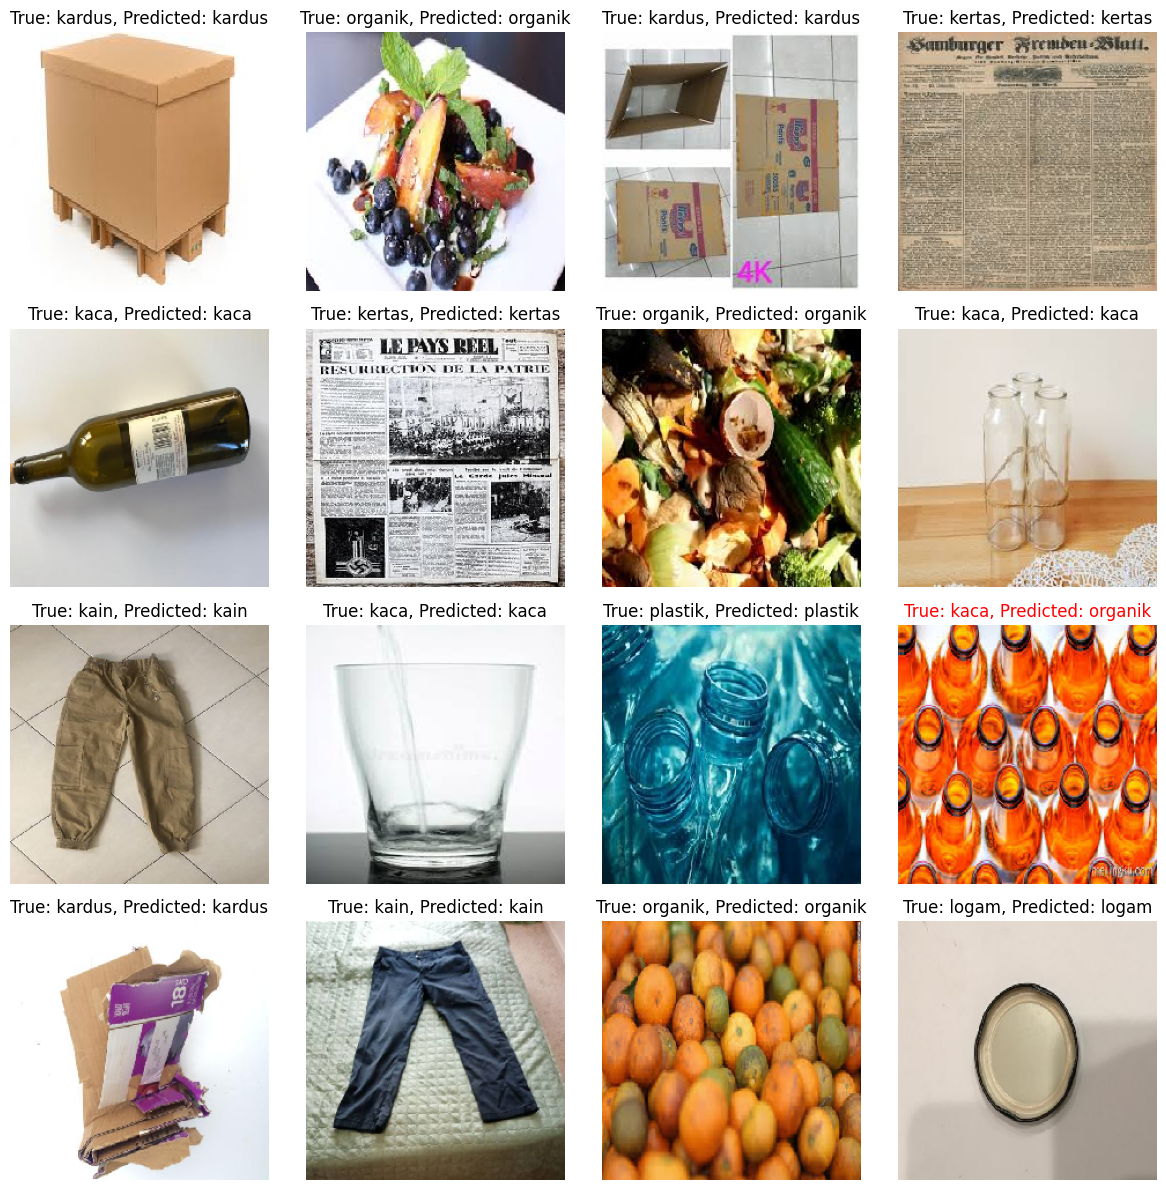

In [73]:
# Set up the subplot with 4 rows and 4 columns
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

axes = axes.flatten()

category = ["elektronik", "kaca", "kain", "kardus", "kertas", "logam", "organik", "plastik"]

# Iterate over each subplot
for i in range(16):
    # Choose a random index
    random_index = np.random.randint(0, len(plot_generator))

    # Retrieve the image and label at the random index using .next()
    image, true_label = plot_generator.next()

    # The image is a batch, so take the first (and only) element and squeeze it
    image = np.squeeze(image[0])
    true_label = np.argmax(true_label[0])

    # Predict the label using your trained model
    predicted_label = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    # Check if true and predicted labels match
    labels_match = true_label == predicted_label

    # Clip pixel values to the valid range [0, 1]
    image = image/255.0

    # Set the title with true and predicted labels, with red color if they don't match
    title = f'True: {category[true_label]}, Predicted: {category[predicted_label]}'
    color = 'red' if not labels_match else 'black'
    axes[i].set_title(title, color=color)

    axes[i].imshow(image)
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


**Convert Model with TensorFlow Lite**

In [ ]:
export_dir = 'model/saved_model'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model/wasteclass_model_v2.tflite')
tflite_model_file.write_bytes(tflite_model)